# Support Vector Regression (SVR) on Tennessee Eastman Process

Tennessee Eastman dataset is a simulated dataset of a chemical plant. For a chemical process sometimes it is essential to accurately predict the difficult-to-measure variables, especially quality as it has a direct impact on the economic operation of the plant.

This notebook uses SVR to estimate the component measure varriables namely XMEAS38 and XMEAS41. The detailed description of the target variables and input pamrameters can be found in the README.

## Importing libraries

In [1]:
import os
import math
import time
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

## Loading and Merging data

TE dataset has total 22 files for each train and test data. The first fike "d00" is for normal operation data and rest 21 is attibuted to 21 different faults. In this case to estimate product quality we will merge all the files.

In [2]:
read_path = r"F:\SEEM\Semester 2\SE\Assignment 1\Spyder\TE_process_2\dataset in CSV\CSVs/"
training_list = []
testing_list = []
for file in os.listdir(read_path):
    if os.path.isfile(os.path.join(read_path, file)):
        if "_te" not in file:
            print("Reading File : ", file)
            training_list.append(pd.read_csv(read_path+file))
        else:
            print("Reading File : ", file)
            testing_list.append(pd.read_csv(read_path+file))

training_data = pd.concat(training_list, sort = False, ignore_index=True)
testing_data = pd.concat(testing_list, sort = False, ignore_index=True)

Reading File :  d00.csv
Reading File :  d00_te.csv
Reading File :  d01.csv
Reading File :  d01_te.csv
Reading File :  d02.csv
Reading File :  d02_te.csv
Reading File :  d03.csv
Reading File :  d03_te.csv
Reading File :  d04.csv
Reading File :  d04_te.csv
Reading File :  d05.csv
Reading File :  d05_te.csv
Reading File :  d06.csv
Reading File :  d06_te.csv
Reading File :  d07.csv
Reading File :  d07_te.csv
Reading File :  d08.csv
Reading File :  d08_te.csv
Reading File :  d09.csv
Reading File :  d09_te.csv
Reading File :  d10.csv
Reading File :  d10_te.csv
Reading File :  d11.csv
Reading File :  d11_te.csv
Reading File :  d12.csv
Reading File :  d12_te.csv
Reading File :  d13.csv
Reading File :  d13_te.csv
Reading File :  d14.csv
Reading File :  d14_te.csv
Reading File :  d15.csv
Reading File :  d15_te.csv
Reading File :  d16.csv
Reading File :  d16_te.csv
Reading File :  d17.csv
Reading File :  d17_te.csv
Reading File :  d18.csv
Reading File :  d18_te.csv
Reading File :  d19.csv
Reading

## Visulaizing the data set

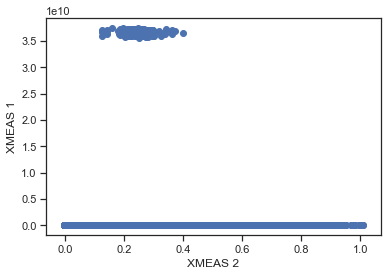

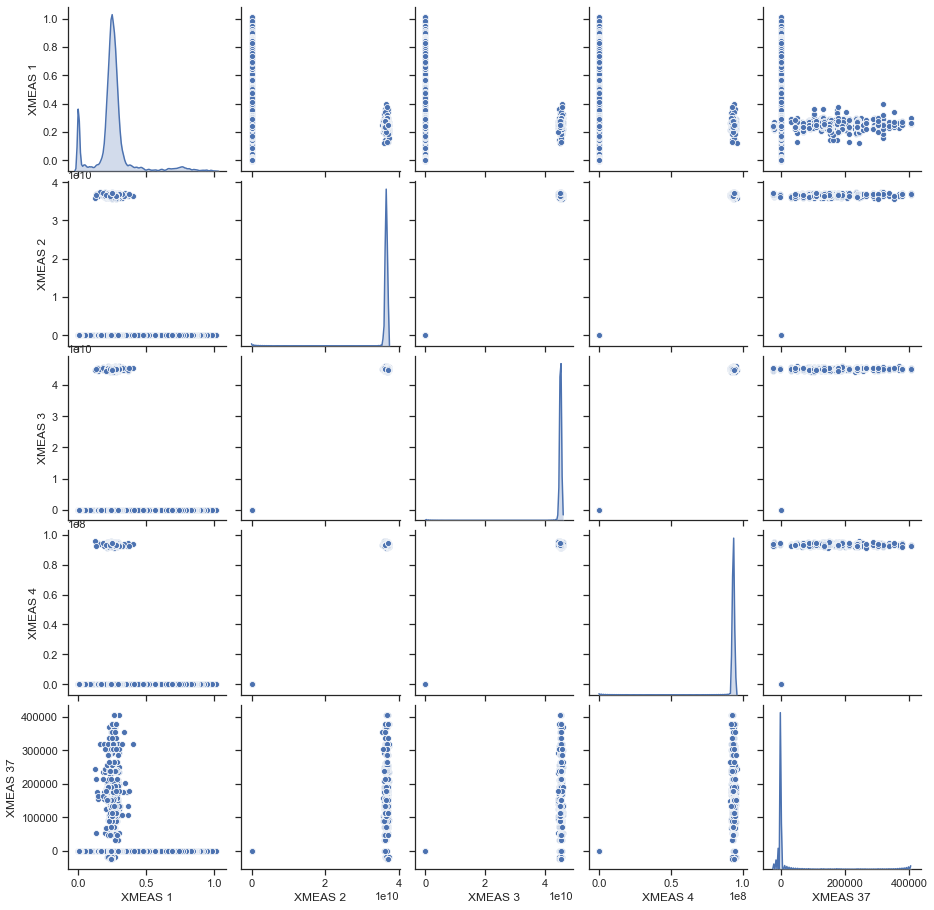

In [3]:
# Scatter plots
fig, ax = plt.subplots()
ax.scatter(training_data['XMEAS 1'],training_data['XMEAS 2'])
ax.set_xlabel('XMEAS 2')
ax.set_ylabel('XMEAS 1')
plt.show(block=False)

# Pair plots
Visul = training_data[['XMEAS 1','XMEAS 2', 'XMEAS 3','XMEAS 4','XMEAS 37']]
sns.pairplot(Visul, diag_kind="kde")

## Preprocessing

In [4]:
training_data = training_data.dropna() 
testing_data = testing_data.dropna()

#removing outliers with Z-score method
z_score = np.abs(stats.zscore(training_data)) 
threshold = 4
training= training_data[(z_score < threshold).all(axis=1)]
print("Training data with outlier ", training_data.shape)
print("Training data without outlier ",training.shape)


Training data with outlier  (10580, 52)
Training data without outlier  (9979, 52)


## Main SVR Function

In [5]:
def SVR_(training,testing,parameter_tobe_estimated):
    #selecting input variables for training
    X_training = training.iloc[:,0:5].values
    y_training = training[parameter_tobe_estimated].values
    
    #scaling input to  zero mean and unit variance
    scale_ = MinMaxScaler(feature_range=(-1, 1))
    X_training_scaled = scale_.fit_transform(X_training)
    
    #SVR with "RBF" kernel
    clf = GridSearchCV(SVR(kernel='rbf', gamma= 0.1), cv=3, param_grid={"C": [0.01,0.1,1,10], "gamma": np.logspace(-5,5,10)})
    t0 = time.time()
    clf.fit(X_training_scaled, y_training)
    svr_fit = time.time() - t0
    
    #Eveluating performance of model on traning dataset
    y_pred_training = clf.predict(X_training_scaled)
    svr_predict_training = time.time() - t0
    train_RMSE = math.sqrt(mean_squared_error(y_training, y_pred_training ))
    train_r2 =  r2_score(y_training, y_pred_training, multioutput='variance_weighted')
    print("RMSE for training data: %.2f" %train_RMSE)
    print('Variance r2_score for training data: %.2f' %train_r2)
        
    #selecting input variables for testing
    X_testing = testing.iloc[:,0:5].values
    y_testing = testing[parameter_tobe_estimated].values
    
    #scaling input to zero mean and unit variance usnig the same parameters as of train data
    X_testing_scaled = scale_.transform(X_testing)
    
    #Applying algorithem to testing dataset and doing prediction
    t0 = time.time()
    y_pred = clf.predict(X_testing_scaled)
    
    svr_predict = time.time() - t0
    
    test_RMSE = math.sqrt(mean_squared_error(y_testing, y_pred))
    print("RMSE for testing data: %.2f"%test_RMSE )
    
    # Explained variance score: 1 is perfect prediction
    test_r2 = r2_score(y_testing, y_pred,multioutput='variance_weighted')
    print('Variance r2_score for testing data: %.2f' %test_r2 )
    
    print("Best parameters set found on development set:", clf.best_params_)
    plt.plot(y_testing, label = 'Test Data')
    plt.plot(y_pred, label = 'Prediction')
    plt.legend(loc='best')
    plt.title('Testing data Vs. Prediction')
    plt.show(block=False)
    return 


RMSE for training data: 0.05
Variance r2_score for training data: 0.68
RMSE for testing data: 0.05
Variance r2_score for testing data: 0.73
Best parameters set found on development set: {'C': 0.1, 'gamma': 0.2782559402207126}


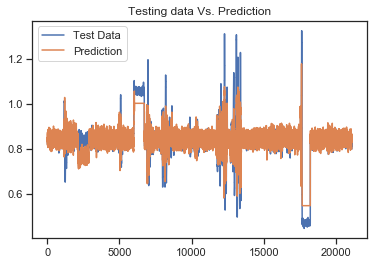

In [6]:
parameter_tobe_estimated = "XMEAS 38"
SVR_(training,testing_data,parameter_tobe_estimated)